In [1]:
%run ../midi2params/interact.py

getting config
getting dataset
loading in dataset fully
getting train
USING AUDIO
train is of length 104
getting val
USING AUDIO
val is of length 21
getting test
USING AUDIO
test is of length 27
making dataloaders
loading model
defining loss function
defining optimizer


In [2]:
for batch in val_loader:
    pass

In [10]:
#batch = trim_and_preprocess(batch, config)

In [3]:
for k, arr in batch.items():
    batch[k] = to_numpy(arr)

In [6]:
batch['loudness_db'].shape

(21, 1250)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1250,)

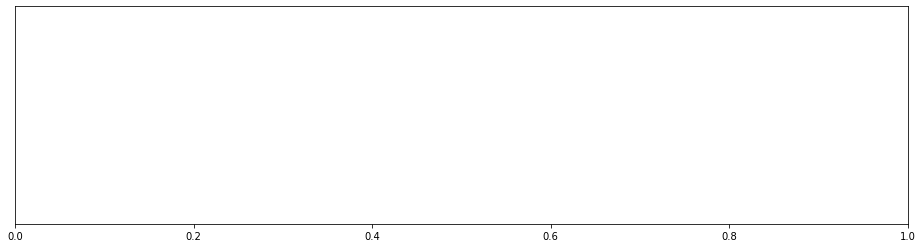

In [4]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
i = 1
start_clip = 0
end_clip = 4
fs = 16000
frame_rate = 250

onsets = np.where(batch['onset_arr'][i] == 1)[0]
offsets = np.where(batch['offset_arr'][i] == 1)[0]

plt.figure(figsize=(16, 4))
plt.yticks([])
#plt.plot(np.arange(start_clip, end_clip, 1/frame_rate),
#         normalize(batch['f0'][i]),
#         alpha=0.75,
#         label='GT f0')
plt.plot(np.arange(start_clip, end_clip, 1/frame_rate),
         normalize(batch['loudness_db'][i]),
         alpha=0.75,
         label='GT loudness')
plt.plot(np.arange(start_clip, end_clip, 1/frame_rate),
         normalize(np.load('ld_predi.npy')),
         alpha=0.75,
         label='predicted loudness')
#plt.plot(np.arange(start_clip, end_clip, 1/frame_rate),
#         normalize(batch['x'][i][:,131+121:].argmax(-1)),
#         alpha=0.75,
#         label='GT loudness (dequant-quant from \'x\')')
plt.plot(onsets / frame_rate - start_clip,
         [0 for o in onsets],
         '^',
         label='midi onsets')
#plt.plot(offsets / frame_rate - start_clip,
#         [0 for o in offsets],
#         '^',
#         label='midi offsets')
#plt.plot(np.arange(start_clip, end_clip, 1/frame_rate),
#         normalize(batch['x'][i][:,:129].argmax(-1)),#normalize(batch['pitches'][i]),
#         alpha=0.75,
#         label='pitch')
plt.xlim(start_clip, end_clip)
plt.legend(loc='upper right')

In [ ]:
model = load_best_model(config, fpath='/juice/scr/rjcaste/curis/wavegenie/wandb/run-20200823_200211-fv0s07yi/best_model.pt')

In [ ]:
batch['x'] = torch.Tensor(batch['x']).cuda()

In [ ]:
cent_logits, ld_logits = model(batch)

In [ ]:
plt.figure(figsize=(16,4))
plt.imshow(F.softmax(ld_logits[i], dim=-1).cpu().detach().numpy().T, origin='lower', cmap=plt.get_cmap('viridis'))

In [ ]:
batch['onset_arr'] = torch.Tensor(batch['onset_arr']).cuda()
batch['offset_arr'] = torch.Tensor(batch['offset_arr']).cuda()

In [ ]:
batch['pitches'] = torch.Tensor(batch['pitches']).cuda()

In [ ]:
cent_logits, ld_logits, cent_out, ld_out = model.generate(batch)

In [ ]:
normalize = lambda x: x - x.min()
plt.figure(figsize=(16,4))
plt.plot(ld_out[i].argmax(-1).cpu().detach().numpy())
plt.plot(normalize(batch['onset_arr']))

In [ ]:
batch['ld_gt_discrete'][i]

In [ ]:
batch['x'][i][:,131+121:].shape

In [ ]:
batch['teacher_forcing_ld'][i].argmax(-1)

In [ ]:
batch['x'][i][:,131+101:].argmax(-1)

In [ ]:
plt.plot(batch['x'][i][:,131+121:].argmax(-1))

In [ ]:
normalize(batch['x'][i][:,:129].argmax(-1)) - normalize(batch['pitches'][i]) < 0.00001

In [ ]:
#@title Select dataset
dataset = 'DDSPViolin_HeuristicVelocityMax'  #@param ['DDSPViolin', 'DDSPViolin_DeadpanMidi_SyntheticAudio', 'DDSPViolin_HumanMidi_SyntheticAudio', "DDSPViolin_HeuristicVelocityMax", "303Static", '303Dynamic']
fs = "16000" #@param [16000, 48000]
split = 'train' #@param ['train', 'valid', 'test']
num_preview = 4#@param {type:"number", min:1, max:10, step:1}
clip_len_seconds = 5#@param {type:"number", min:1, max:10, step:1}
seed = 0#@param {type:"number", min:1, max:10, step:1}
plot_waveform = True#@param {type:"boolean"}
plot_f0 = True#@param {type:"boolean"}
plot_loudness = True#@param {type:"boolean"}
plot_midi = True#@param {type:"boolean"}

from io import BytesIO
import tempfile
import os
import pickle
import random
import tarfile

import numpy as np
import pretty_midi
from scipy.io.wavfile import read as wavread
from IPython.display import display, Audio

import matplotlib.pyplot as plt

fs = int(fs)
PARAMS_FS = 250

normalize = lambda x: (x - x.min()) / (x.max() - x.min())


# Load wav
wav_fp = os.path.join('wav', '{}.wav'.format(fn))
wavfs, wav = wavread(BytesIO(get_fn_bytes(wav_fp)))
assert wavfs == fs
assert wav.min() >= -1 and wav.max() <= 1 and wav.dtype == np.float32
wav_len_seconds = wav.shape[0] / fs

# Select clip from wav
wav = np.pad(wav, (int(clip_len_seconds * fs), int(clip_len_seconds * fs)))
clip = wav[
                     int((clip_len_seconds + clip_start_seconds) * fs)
                     :
                     int((clip_len_seconds + clip_end_seconds) * fs)]

# Create plot
plt.figure(figsize=(16, 4))
plt.yticks([])
if plot_waveform:
    plt.plot(
            np.arange(clip_start_seconds, clip_end_seconds, 1./fs),
            normalize(clip),
            label='waveform',
            alpha=0.25)

# Preview clip
print('-' * 10)
print('Audio')

if plot_f0 or plot_loudness:
    plot_params = []
    if plot_f0:
        plot_params.extend(['f0_hz', 'f0_confidence'])
    if plot_loudness:
        plot_params.extend(['loudness_db_centered'])
    for k in plot_params:
        param = params[k]
        param = np.pad(param, (int(clip_len_seconds * PARAMS_FS), int(clip_len_seconds * PARAMS_FS)))
        clip = param[
                        int((clip_len_seconds + clip_start_seconds) * PARAMS_FS)
                        :
                        int((clip_len_seconds + clip_end_seconds) * PARAMS_FS)]
        alpha = 0.25 if k in ['f0_confidence', 'loudness_db'] else 1.
        plt.plot(
                np.arange(clip_start_seconds, clip_end_seconds, 1./PARAMS_FS),
                normalize(clip),
                label=k,
                alpha=alpha
        )
        #plt.show()

# Preview MIDI
if plot_midi:
    notes = ins.notes
    clip_notes = [n for n in notes if n.end >= clip_start_seconds and n.start <= clip_end_seconds]
    clip_onsets = [(n.start, n.velocity) for n in clip_notes if n.start >= clip_start_seconds]
    clip_offsets = [n.end for n in clip_notes if n.end <= clip_end_seconds]
    plt.plot(
            [s for s, _ in clip_onsets],
            [v / 127 for _, v in clip_onsets],
            '^', label='midi_onsets')
    plt.plot(clip_offsets, [0.0] * len(clip_offsets), 'v', label='midi_offsets')

# Show plot
plt.legend(loc='upper right')
plt.show()

In [ ]:
batch['x'].requires_grad = True

In [ ]:
cent_logits, ld_logits = model(batch)

In [ ]:
loss = ld_logits[0, 300].sum()

In [ ]:
loss.backward()

In [ ]:
batch['x'].shape

In [ ]:
plt.imshow(batch['x'].grad.cpu().numpy()[0,:].T, cmap='hot')
plt.xticks(np.arange(0, 1000, 100))

In [ ]:
set(np.where(batch['x'].grad.cpu().numpy() != 0)[1])

In [ ]:
len(set(np.where(batch['x'].grad.cpu().numpy() != 0)[1]))

In [ ]:
plt.imshow(batch['x'].grad[0].detach().cpu().numpy())

In [ ]:
y_pred = cent_logits

if config.training.gaussian_during_train:
    cents_loss_gauss = loss_fn_soft(y_pred, batch['f0_gt_gauss'])

y_pred = y_pred.view(-1, 101)
batch['f0_gt_discrete'] = batch['f0_gt_discrete'].reshape(-1)

cents_loss_discrete = loss_fn_discrete(y_pred, batch['f0_gt_discrete'])

#################
# LOUDNESS LOSS #
#################

y_pred = ld_logits

if config.training.gaussian_during_train:
    ld_loss_gauss = loss_fn_soft(y_pred, batch['ld_gt_gauss'])

y_pred = y_pred.view(-1, 121)
batch['ld_gt_discrete'] = batch['ld_gt_discrete'].reshape(-1)

ld_loss_discrete = loss_fn_discrete(y_pred, batch['ld_gt_discrete'])

###################################
# COMPUTE TOTAL LOSS AND BACKPROP #
###################################

loss_discrete = cents_loss_discrete + ld_loss_discrete
if config.training.gaussian_during_train:
    loss_gauss = cents_loss_gauss + ld_loss_gauss
    loss = loss_gauss
else:
    loss = loss_discrete

In [ ]:
loss.backward()

In [ ]:
batch['x'].grad.shape

In [ ]:
x = torch.tensor([4.], requires_grad=True)
y = torch.tensor([5.], requires_grad=True)
z = x + y
z.backward()

In [ ]:
y.grad

In [ ]:
for i in range(104):
    plt.title(i)
    plt.plot(batch['loudness_db'][i])
    plt.plot(batch['onset_arr'][i] * 80 - 120)
    plt.plot(batch['pitches'][i] - 120)
    plt.xlim(0, 1000)
    plt.show()

In [ ]:
np.where(batch['pitches'] == 0)

In [ ]:
from wavegenie.util import preview_audio
i = 99
audio = np.array(batch['audio'][i])[..., np.newaxis].astype(np.float32)
plt.title(i)
plt.plot(batch['loudness_db'][i])
plt.plot(batch['onset_arr'][i] * 80 - 120)
plt.plot(batch['pitches'][i] - 120)
plt.xlim(0, 1000)
plt.show()
preview_audio(audio)

In [ ]:
audio

In [ ]:
from wavegenie.util import extract_ddsp_synthesis_parameters

params = extract_ddsp_synthesis_parameters(audio.T)

In [ ]:
plt.plot(params['loudness_db'])

In [ ]:
batch = trim_and_preprocess(batch, config)

In [ ]:
import pickle
batch40 =pickle.load(open('40batch.p', 'rb'))

In [ ]:
plt.plot(batch40['loudness_db'][0])
plt.plot(batch['loudness_db'][0])

In [ ]:
plt.plot(batch40['ld_gt_discrete'][0])
plt.plot(batch['ld_gt_discrete'][0])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(batch40['teacher_forcing_ld'][0].T, origin='lower')
plt.title('Teacher forcing loudness, shifted back 40 steps')
plt.xlim(0, 1000)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(batch['teacher_forcing_ld'][0].T, origin='lower')
plt.title('Teacher forcing loudness, original position')
plt.xlim(0, 1000)
plt.show()

In [ ]:
batch.keys()

In [ ]:
import pickle
pickle.dump(batch, open('40batch.p', 'wb'))

In [ ]:
f0 = batch['f0']

In [ ]:
plt.plot(f0perturbed[1], label='-40')
plt.plot(f0[1], label='0')
plt.legend()

In [ ]:
np.save('f0perturbed.npy', newbatch['f0'][0])

In [ ]:
f0save = np.load('f0perturbed.npy')

In [ ]:
f0save[600:700]

In [ ]:
newbatch['f0'][0][600:700]

In [ ]:
plt.plot(np.array(newbatch['f0'][0,600:700]))

In [ ]:
plt.plot(newbatch['f0'][0])

In [ ]:
plt.plot(f0save)

In [ ]:
for batch in val_loader:
    pass

In [ ]:
np.save('f0save.npy', batch['f0'][0,600:700])

In [ ]:
newbatch['f0'][0,600:700] - batch['f0'][0,600:700]

In [ ]:
batch['f0'][0,600:700]

In [ ]:
plt.plot(batch['f0'][0,600:700])

In [ ]:
batch.keys()

In [ ]:
np.where((batch['onset_arr'] != batch['offset_arr']))

In [ ]:
i = 3
plt.plot(batch['pitches'][i])
plt.show()
plt.plot(batch['f0'][i])
plt.plot(batch['onset_arr'][i] * 600)
plt.plot(batch['offset_arr'][i] * 400)
plt.show()
plt.plot(batch['loudness_db'][i])
plt.plot(batch['onset_arr'][i] * 90 - 120)
plt.plot(batch['offset_arr'][i] * 50 - 120)

In [ ]:
batch = trim_and_preprocess(batch, config)

In [ ]:
batch['pitches'].shape

In [ ]:
batch['teacher_forcing_f0'][:,0].unsqueeze(1).shape

In [ ]:
idx = 0
plt.figure(figsize=(16,5))
plt.plot(batch['f0'][idx])

In [ ]:
batch.keys()

In [ ]:
plt.plot(batch['loudness_db'][idx])

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(batch['teacher_forcing_f0'][idx].T, origin='lower')

In [ ]:
F.one_hot(batch['ld_gt_discrete'][idx], num_classes=121).shape

In [ ]:
batch['teacher_forcing_ld'][idx].T.shape

In [ ]:
teacher_ld = batch['teacher_forcing_ld'][idx].T
gt_ld = F.one_hot(batch['ld_gt_discrete'][idx], num_classes=121).T.float()

In [ ]:
teacher_f0 = batch['teacher_forcing_f0'][idx].T
gt_f0 = F.one_hot(batch['f0_gt_discrete'][idx], num_classes=121).T.float()

In [ ]:
plt.imshow(teacher[75:85,100:115] - gt[75:85,100:115], origin='lower')
plt.title('(teacher forcing f0) - (ground truth f0)')

In [ ]:
np.where(batch['pitches'][0] != 0)[0]

In [ ]:
plt.plot(batch['pitches'][0])

In [ ]:
plt.plot(batch['onset_arr'][0])

In [ ]:
plt.plot(batch['offset_arr'][0])

In [ ]:
plt.imshow(teacher_f0, origin='lower')

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.title('teacher forcing f0')
plt.imshow(teacher_f0[30:50,100:115], origin='lower')
plt.subplot(2, 1, 2)
plt.title('ground truth f0')
plt.imshow(gt_f0[30:50,100:115], origin='lower')

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.title('teacher forcing ld')
plt.imshow(teacher_ld[60:90,100:115], origin='lower')
plt.subplot(2, 1, 2)
plt.title('ground truth ld')
plt.imshow(gt_ld[60:90,100:115], origin='lower')

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plt.imshow(teacher, origin='lower')
plt.xlim(0, 1000)
plt.subplot(2, 1, 2)
plt.imshow(gt, origin='lower')
#plt.plot(batch['loudness_db'][idx])
plt.xlim(0, 1000)